In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import perturbseq as perturb

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/A549.'+PROTEIN

counts=20000

FIGS=DATA+'/2020-09-15_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2020-09-15_Figures/


In [3]:
adata=sc.read(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.regress_out_vbc.analysis.1000cells.new_format.h5ad',cache=False)
adata

Only considering the two last: ['.new_format', '.h5ad'].
Only considering the two last: ['.new_format', '.h5ad'].


AnnData object with n_obs × n_vars = 90262 × 1145 
    obs: 'batch', 'known', 'n_counts', 'n_genes', 'percent_mito', 'n_counts_downsampled', 'n_counts_original', 'vbc.counts', 'batch_num4', 'batch_num7', 'batch_num11', 'batch_num8', 'batch_num13', 'batch_num23', 'batch_num9', 'batch_num2', 'batch_num24', 'batch_num10', 'batch_num12', 'batch_num16', 'batch_num20', 'batch_num18', 'batch_num25', 'batch_num31', 'batch_num28', 'batch_num5', 'batch_num14', 'batch_num15', 'batch_num29', 'batch_num3', 'batch_num6', 'batch_num22', 'batch_num26', 'batch_num17', 'batch_num27', 'batch_num1', 'batch_num19', 'batch_num21', 'batch_num0', 'batch_num30', 'louvain', 'G1.S', 'G2.M', 'M', 'M.G1', 'S', 'phase.multi', 'guide', 'guide.compact', 'A146P', 'K117R', 'Y166H', 'K169K', 'K178K', 'T50P', 'A146V', 'L52F', 'K176Q', 'A155G', 'G60D', 'T158T', 'K88K', 'D119G', 'L159S', 'G13V', 'Q61P', 'D33E', 'S136N', 'K179R', 'T74T', 'G60S', 'Q99E', 'G13R', 'G12D', 'R164Q', 'I36M', 'C185Y', 'I163S', 'P34R', 'G60V', 'G12

In [4]:
ref='K169K'
methods=['bulk.L1','HotellingT2','bulk.spearman','bulk.pearson']

#collect the variants into a list
variants=perturb.util.get_perturbations(adata,compact=True)
variants.append('unassigned')
print(variants)
print(len(variants))

['A130V', 'A146P', 'A146T', 'A146V', 'A155G', 'A59E', 'A59G', 'A59T', 'A66A', 'AG11TD', 'AG59GV', 'C118S', 'C185Y', 'D119G', 'D173D', 'D30D', 'D33E', 'D57N', 'E31K', 'E63K', 'F141L', 'G12A', 'G12C', 'G12D', 'G12F', 'G12I', 'G12R', 'G12S', 'G12V', 'G12Y', 'G13C', 'G13E', 'G13R', 'G13V', 'G60D', 'G60S', 'G60V', 'G75A', 'G77A', 'I163S', 'I36M', 'K117N', 'K117R', 'K147N', 'K147T', 'K169K', 'K176Q', 'K178K', 'K179R', 'K5E', 'K88K', 'L159S', 'L19F', 'L52F', 'L79I', 'M111L', 'M170L', 'N26Y', 'P110S', 'P34L', 'P34R', 'Q22H', 'Q22K', 'Q25H', 'Q61A', 'Q61H', 'Q61K', 'Q61L', 'Q61P', 'Q61R', 'Q99E', 'R135T', 'R149K', 'R164Q', 'R41K', 'R68S', 'S136N', 'S17S', 'T127T', 'T144P', 'T144T', 'T158A', 'T158T', 'T20M', 'T20R', 'T20T', 'T50I', 'T50P', 'T50T', 'T58I', 'T74A', 'T74T', 'V112I', 'V14I', 'V14L', 'V8V', 'WT', 'Y166H', 'unassigned']
99


In [3]:
#============ COMPARING PERTURBATIONS
def compare_2_groups_df(adata_df,
                     group1_cells,group2_cells,
                     method,
                     ps=1e-300):
    
    v1_data=adata_df.loc[group1_cells,:]
    v2_data=adata_df.loc[group2_cells,:]

    #T2 Hotelling
    #============
    if method=='HotellingT2':
        import spm1d
        
        T2=spm1d.stats.hotellings2(v1_data,v2_data)
        ##T2i=T2.inference(0.0005)
        ##pval=T2i.p+ps #p-value
        value=T2.z #the T2 statistic

    #bulk analysis
    #==============
    if 'bulk' in method:
        #get the bulkified data
        v1_bulk=np.mean(np.array(v1_data),axis=0)
        v2_bulk=np.mean(np.array(v2_data),axis=0)

    if method=='bulk.pearson':
        from scipy.stats import pearsonr
        value=1-pearsonr(v1_bulk,v2_bulk)[0]

    if method=='bulk.spearman':
        from scipy.stats import spearmanr
        value=1-spearmanr(v1_bulk,v2_bulk)[0]
        
    if method=='bulk.L1':
        value=np.sum(np.abs(v1_bulk-v2_bulk))*1.0/v1_data.shape[1]

    return(value)

def compare_two_groups(adata_here,
                       v1,v2,
                       methods=['HotellingT2','bulk.pearson','bulk.spearman','bulk.L1'],
                       num_pcs_hotelling=20):
    #convert the adata to a data frame here
    data_here=pd.DataFrame(adata_here.X,
                          columns=adata_here.var_names,
                         index=adata_here.obs_names)
    if 'HotellingT2' in methods:
        data_here_pca=pd.DataFrame(adata_here.obsm['X_pca'][:,:num_pcs_hotelling],
                             index=adata_here.obs_names)
    
    v1_cells=adata_here.obs_names[adata_here.obs[v1]>0]
    v2_cells=adata_here.obs_names[adata_here.obs[v2]>0]
    
    comparison_name=v1+'.VS.'+v2
    cols=['group1','group2']
    for m in methods:
        cols.append(m)
    df_comparison=pd.DataFrame(0,columns=cols,index=[comparison_name])
    
    for method in methods:
        if method=='HotellingT2':
            v=compare_2_groups_df(data_here_pca,v1_cells,v2_cells,method)
        else:
            v=compare_2_groups_df(data_here,v1_cells,v2_cells,method)
        df_comparison.loc[comparison_name,method]=v
        df_comparison.loc[comparison_name,'group1']=v1
        df_comparison.loc[comparison_name,'group2']=v2
    df_comparison=df_comparison.reset_index(drop=True)
        
    return(df_comparison)



def compare_groups_with_reference(adata_here,
                                 groups,
                                 reference,
                                 methods=['HotellingT2','bulk.pearson','bulk.spearman','bulk.L1'],
                                 num_pcs_hotelling=20,
                                 permuted=False):
    
    if permuted:
        permuted_df=adata_here.uns['permuted']
        for label in permuted_df.columns:
            adata_here.obs['permuted.'+label]=list(permuted_df[label])
    
    results_col=['group1','group2']
    for c in methods:
        results_col.append(c)
    results=pd.DataFrame(columns=results_col)
    
    for group in groups:
        group_final=group
        ref_final=reference
        if permuted:
            group_final='permuted.'+group
            ref_final='permuted.'+reference
        x=compare_two_groups(adata_here,
                     ref_final,group_final,
                    methods,
                    num_pcs_hotelling)
        results=pd.concat([results,x],axis=0)
        
    if permuted:
        permuted_df=adata_here.uns['permuted']
        for label in permuted_df.columns:
            del adata_here.obs['permuted.'+label]
            
    return(results)

def permute_labels(adata_here,
                  groups,
                  copy_adata=False,
                  seedname=0):
    import copy
    
    if copy_adata:
        adata_here=copy.deepcopy(adata_here)
    
    df_here=adata_here.obs.loc[:,groups]
    
    #permute the order of the rows
    permuted_order=df_here.sample(frac=1,random_state=seedname).reset_index(drop=True)
    
    adata_here.uns['permuted']=permuted_order
    
    if copy_adata:
        return(adata_here)
    
#run for permuted data. need to do this in a way that can be automated for the user
def get_permuted_scores(adata_here,
                        variants,
                        reference,
                       num_perm=10,
                        methods=['HotellingT2','bulk.pearson','bulk.spearman','bulk.L1'],
                        num_pcs_hotelling=20):
    
    started=False
    for perm in range(num_perm):
        print('permutation',perm)
        permute_labels(adata_here,variants,seedname=perm)
        res_perm=compare_groups_with_reference(adata_here,
                                 variants,
                                 reference,
                                 permuted=True,
                                methods=methods,
                                num_pcs_hotelling=num_pcs_hotelling)
        if not started:
            perm_scores=res_perm
            started=True
        else:
            perm_scores=pd.concat([perm_scores,res_perm],axis=0)
    del adata_here.uns['permuted']
            
    return(perm_scores)

def get_threshold_at_FDR(fdr_data,method,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data['FDR.'+method]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)

def compute_FDR(res_true,res_perm,methods,plot=False,FDR=0.01):
    
    res_true['dataset']='true data'
    res_perm['dataset']='permuted data'
    res_combo=pd.concat([res_true,res_perm],axis=0)
    min_fdr=1.0/res_combo.shape[0]
    for method in methods:
        res_combo=res_combo.sort_values(by=method,ascending=False)
        res_combo['FDR.'+method]=1
        res_combo=res_combo.reset_index(drop=True)
        for i in range(res_combo.shape[0]):
            value_here=float(list(res_combo[method])[i])
            idx=list(res_combo.index)[i]
            passed=res_combo.loc[res_combo[method]>=value_here,:]
            true_pass=np.sum(passed['dataset']=='true data')
            perm_pass=np.sum(passed['dataset']=='permuted data')
            
            true_fraction=1.0*true_pass/res_true.shape[0]
            perm_fraction=1.0*perm_pass/res_perm.shape[0]
            
            fdr_here=max(float(1.0*perm_fraction/(perm_fraction+true_fraction)),
                            float(min_fdr))       
            res_combo.loc[idx,'FDR.'+method]=float(fdr_here)
            
        if plot:
            #get even bins
            NUM_BINS=20
            max_val=np.max(res_combo[method])
            mybins=[x*max_val/NUM_BINS for x in range(NUM_BINS)]
            scores_true=res_combo.loc[res_combo['dataset']=='true data',method]
            scores_perm=res_combo.loc[res_combo['dataset']=='permuted data',method]
            plt.hist(scores_true,color='red',bins=mybins,label='Real data')
            plt.hist(scores_perm,color='black',alpha=0.5,bins=mybins,
                     weights=[len(scores_true)/len(scores_perm)]*len(scores_perm),
                    label='Permuted data')
            plt.grid(False)
            plt.xlabel(method)
            plt.ylabel('Frequency')
            #thresh_data=res_combo.loc[res_combo['FDR.'+method]<=0.01,:]
            #thresh_data=thresh_data.sort_values(by=method,ascending=True)
            #thresh=list(thresh_data[method])[0]
            thresh=get_threshold_at_FDR(res_combo.loc[res_combo['dataset']=='true data',:],method,FDR)
            thresh=int(1000*thresh)/1000
            plt.axvline(x=thresh,color='black',linestyle='dotted')
            plt.title('FDR '+str(FDR)+' threshold: '+str(thresh))
            plt.legend()
            plt.show()

    to_return=res_combo.loc[res_combo['dataset']=='true data',:]
    to_return=to_return.drop(columns=['dataset'])
    return(to_return)
    


In [6]:
#compute scores
scores_real=compare_groups_with_reference(adata,
                                         variants,
                                         ref,
                                         methods=methods)

permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9


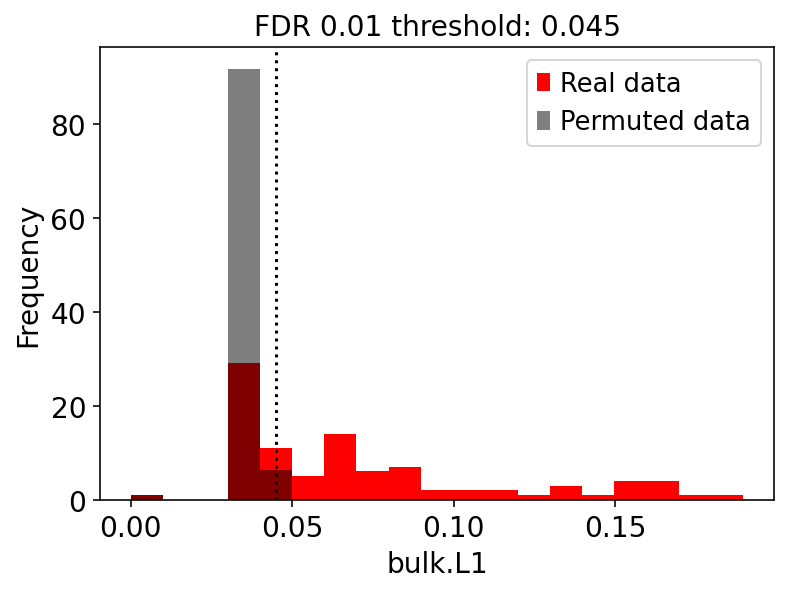

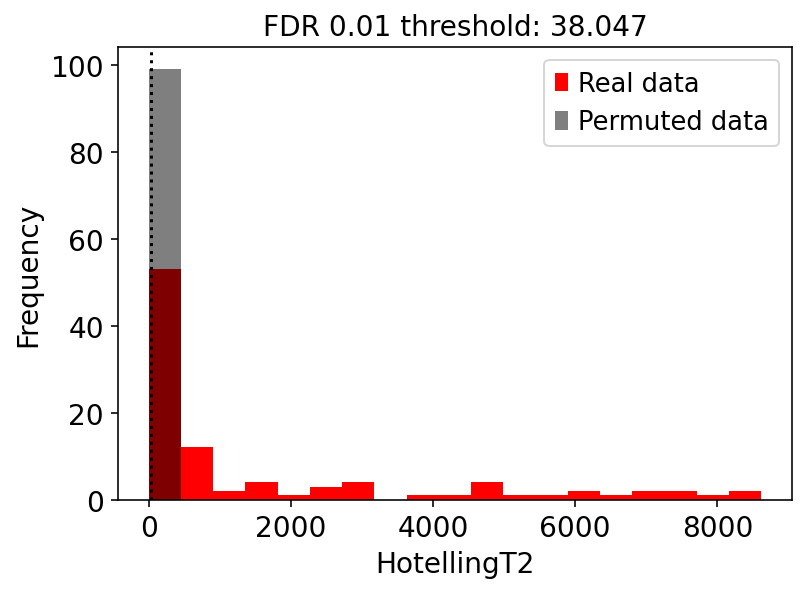

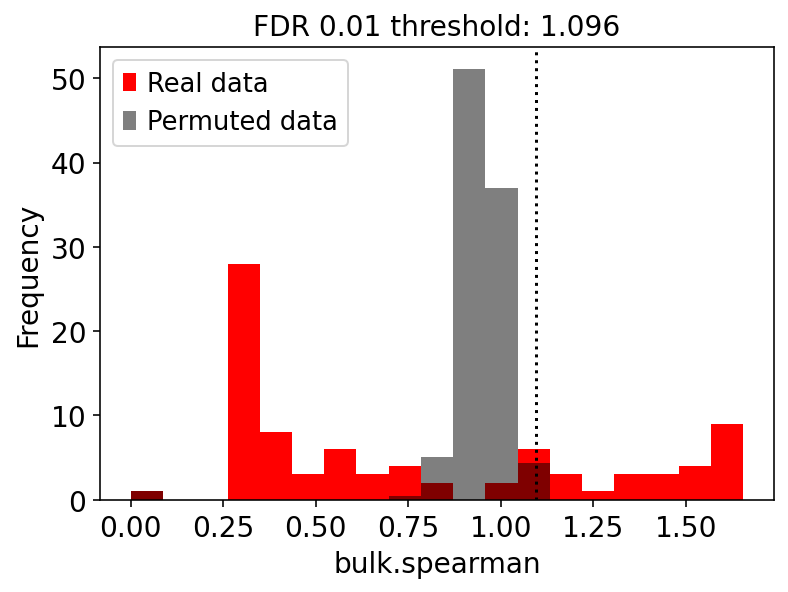

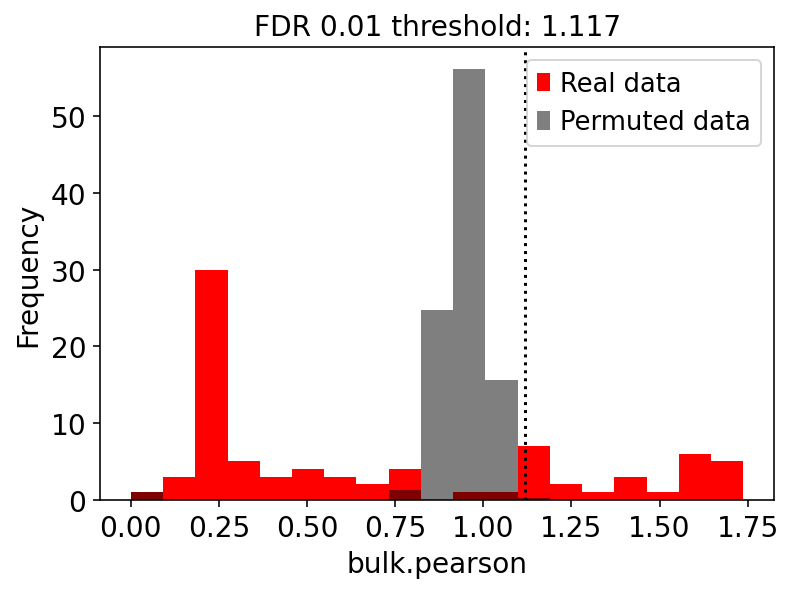

In [7]:
#get empirical distribution of scores on permuted data
scores_perm=get_permuted_scores(adata,
                                variants,
                                ref,
                                num_perm=10,
                                methods=methods)


#assign FDR based on permuted data
fdr_data=compute_FDR(scores_real,
                     scores_perm,
                     methods=methods,
                     plot=True)

In [8]:
score_thresh_value_perm1=get_threshold_at_FDR(fdr_data,method='HotellingT2',FDR=0.01)

In [9]:
#read in the annotation file to add the clusters to it
FDR=0.01
#original anno
ANNO=DATA+'/'+PROTEIN+'/anno'
anno=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.complete2.csv',sep='\t')
anno.index=anno['Variant']

anno['Position']=anno['Position'].astype('Int32')
anno['Count_pancan']=anno['Count_pancan'].astype('Int32')
anno['Count_ExAC']=anno['Count_ExAC'].astype('Int32')

syn=list(set(anno.loc[anno['control_status']=='synonymous','Variant']).intersection(set(variants)))
print(syn)
anno.head()

['D30D', 'T50T', 'T158T', 'T127T', 'A66A', 'T74T', 'T144T', 'V8V', 'K169K', 'WT', 'D173D', 'K88K', 'T20T', 'S17S', 'K178K']


,Variant,Variant.1,Position,From,To,mutation_type,Count_pancan,Count_ExAC,control_status,control_color,Library_synthesis,long_name,control_status2,text_color
Variant,,,,,,,,,,,,,,
G12D,G12D,G12D,12,C,T,Single,1782,NaN,unknown,white,in,KRAS_G12D,hotspot,red
G12V,G12V,G12V,12,C,A,Single,1539,NaN,unknown,white,in,KRAS_G12V,hotspot,red
G12C,G12C,G12C,12,C,A,Single,1110,NaN,unknown,white,in,KRAS_G12C,hotspot,red
G13D,G13D,G13D,13,C,T,Single,582,NaN,unknown,white,not in library,NaN,hotspot,red
G12A,G12A,G12A,12,C,G,Single,353,NaN,unknown,white,in,KRAS_G12A,hotspot,red


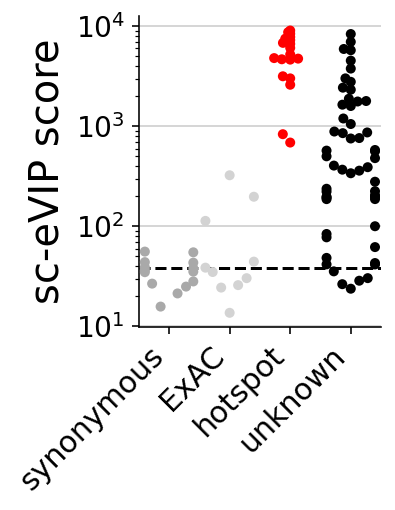

In [10]:
score='HotellingT2'
fdr_data['control_status2']=list(anno.loc[fdr_data['group2'],'control_status2']) 

mypal={'synonymous':'darkgray',
      'ExAC':'lightgray','hotspot':'red','unknown':'black'}
g =sns.catplot(x="control_status2", y=score, 
              order=['synonymous','ExAC','hotspot','unknown'],
              height=3, 
                aspect=1,legend=False,kind='swarm',data=fdr_data,
              hue='control_status2',palette=mypal)

ax1 = g.axes[0,0]
ax1.axhline(y=score_thresh_value_perm1,color='black',linestyle='--')
ax1.set_xlabel('',fontsize=20)
ax1.set_ylabel('sc-eVIP score',fontsize=20)
ax1.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,fontsize=15,
                   ha='right')
ax1.set_yscale('log')

plt.savefig(FIGS+'/'+PROTEIN+'.sceVIPscore_swarm.normal_perm.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.sceVIPscore_swarm.normal_perm.png',bbox_inches = "tight")

In [11]:
def permute_labels_custom(adata_here,
                  groups,
                  reference,
                  copy_adata=False,
                  seedname=0):
    import copy
    
    if copy_adata:
        adata_here=copy.deepcopy(adata_here)
    
    df_here=adata_here.obs.loc[:,groups]
    
    #permute the columns
    permuted_order=df_here.T.sample(frac=1,random_state=seedname).T
    permuted_order.columns=groups
    
    #make sure the reference has as many cells as it had originally
    num_cells_reference=int(df_here.sum(axis=0)[reference])
    new_reference_cells=adata_here.obs_names[permuted_order[reference]>0]
    permuted_order.index=adata_here.obs_names
    
    if len(new_reference_cells)>num_cells_reference:
        permuted_order[reference]=0
        permuted_order.loc[new_reference_cells[:num_cells_reference],reference]=1
    
    adata_here.uns['permuted']=permuted_order
    
    if copy_adata:
        return(adata_here)

def get_permuted_scores_custom(adata_here,
                        groups,
                        reference,
                       num_perm=10,
                        methods=['HotellingT2','bulk.pearson','bulk.spearman','bulk.L1'],
                        num_pcs_hotelling=20):
    
    started=False
    for perm in range(num_perm):
        print('permutation',perm)
        permute_labels_custom(adata_here,
                  groups,reference,
                  copy_adata=False,
                    seedname=perm)
        res_perm=compare_groups_with_reference(adata_here,
                                 groups,
                                 reference,
                                 permuted=True,
                                methods=methods,
                                num_pcs_hotelling=num_pcs_hotelling)
        if not started:
            perm_scores=res_perm
            started=True
        else:
            perm_scores=pd.concat([perm_scores,res_perm],axis=0)
            
    return(perm_scores)

permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



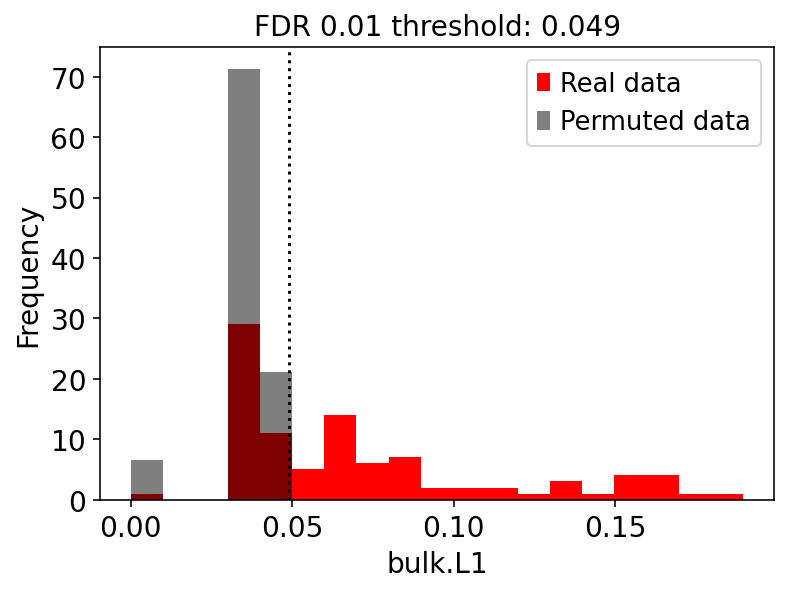

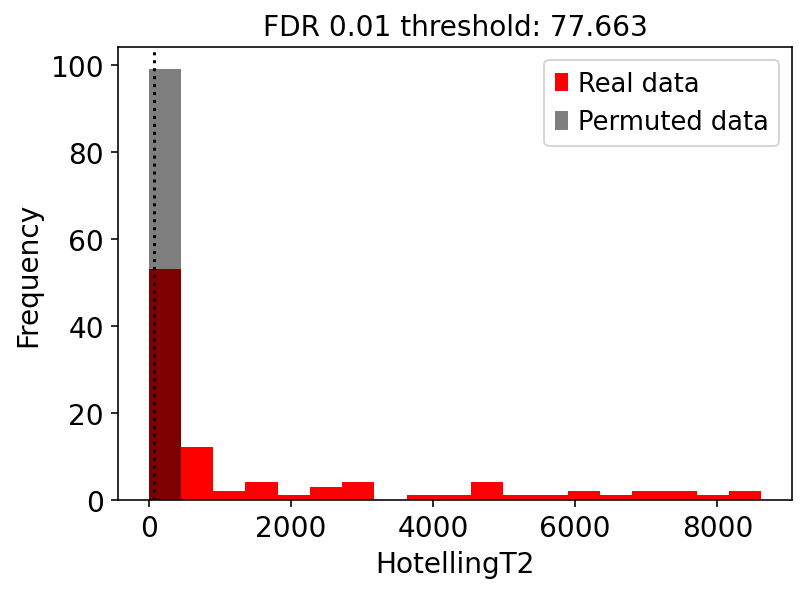

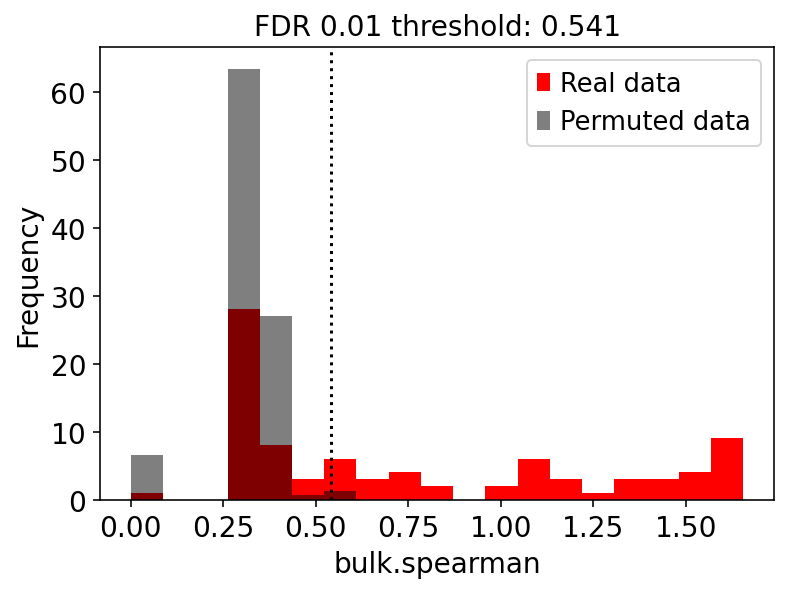

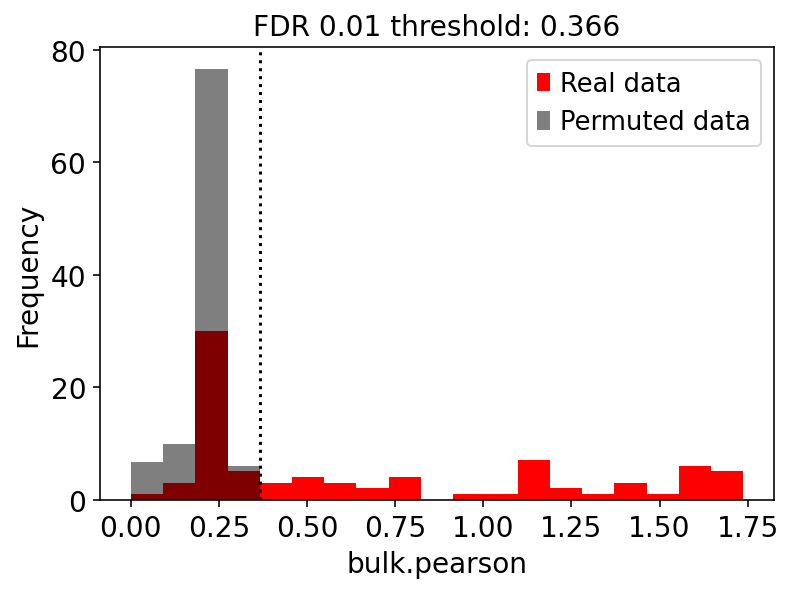

In [12]:
scores_perm_custom=get_permuted_scores_custom(adata,
                                                         syn,
                                                         ref,
                                                         num_perm=10)

#assign FDR based on permuted data
fdr_data=compute_FDR(scores_real,
                                scores_perm_custom,
                                 methods=methods,
                                 plot=True)

In [13]:
score_thresh_value_perm2=get_threshold_at_FDR(fdr_data,method='HotellingT2',FDR=0.01)

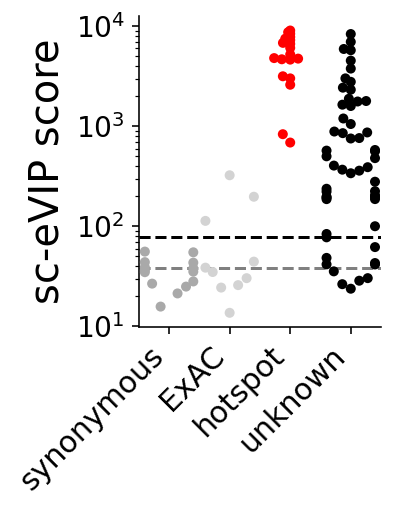

In [17]:
score='HotellingT2'
fdr_data['control_status2']=list(anno.loc[fdr_data['group2'],'control_status2']) 

mypal={'synonymous':'darkgray',
      'ExAC':'lightgray','hotspot':'red','unknown':'black'}
g =sns.catplot(x="control_status2", y=score, 
              order=['synonymous','ExAC','hotspot','unknown'],
              height=3, 
                aspect=1,legend=False,kind='swarm',data=fdr_data,
              hue='control_status2',palette=mypal)

ax1 = g.axes[0,0]
ax1.axhline(y=score_thresh_value_perm1,color='gray',linestyle='--')
ax1.axhline(y=score_thresh_value_perm2,color='black',linestyle='--')
ax1.set_xlabel('',fontsize=20)
ax1.set_ylabel('sc-eVIP score',fontsize=20)
ax1.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,fontsize=15,
                   ha='right')
ax1.set_yscale('log')
ax1.grid(False)

plt.savefig(FIGS+'/'+PROTEIN+'.sceVIPscore_swarm.perm_comparison.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.sceVIPscore_swarm.perm_comparison.png',bbox_inches = "tight")

In [15]:
#save scores
fdr_data.to_csv(DATA+'/'+PROTEIN+'/scoring/'+PROTEIN+'.scores_vs_'+ref+'.csv')

In [16]:
print(variants)

['A130V', 'A146P', 'A146T', 'A146V', 'A155G', 'A59E', 'A59G', 'A59T', 'A66A', 'AG11TD', 'AG59GV', 'C118S', 'C185Y', 'D119G', 'D173D', 'D30D', 'D33E', 'D57N', 'E31K', 'E63K', 'F141L', 'G12A', 'G12C', 'G12D', 'G12F', 'G12I', 'G12R', 'G12S', 'G12V', 'G12Y', 'G13C', 'G13E', 'G13R', 'G13V', 'G60D', 'G60S', 'G60V', 'G75A', 'G77A', 'I163S', 'I36M', 'K117N', 'K117R', 'K147N', 'K147T', 'K169K', 'K176Q', 'K178K', 'K179R', 'K5E', 'K88K', 'L159S', 'L19F', 'L52F', 'L79I', 'M111L', 'M170L', 'N26Y', 'P110S', 'P34L', 'P34R', 'Q22H', 'Q22K', 'Q25H', 'Q61A', 'Q61H', 'Q61K', 'Q61L', 'Q61P', 'Q61R', 'Q99E', 'R135T', 'R149K', 'R164Q', 'R41K', 'R68S', 'S136N', 'S17S', 'T127T', 'T144P', 'T144T', 'T158A', 'T158T', 'T20M', 'T20R', 'T20T', 'T50I', 'T50P', 'T50T', 'T58I', 'T74A', 'T74T', 'V112I', 'V14I', 'V14L', 'V8V', 'WT', 'Y166H', 'unassigned']


In [23]:
#mega subsampling
SUBSAMPLING_LIST=[1000,900,800,700,600,500,400,300,200] #then every 10
SUBSAMPLING_LIST=[190,180,170,160,150,140,130,120,110,100,90,80,70,60,50,40,30,20,10]
ITERATIONS=range(10)
ref='K169K'
methods=['HotellingT2']
#synonymous
OUT_PREF=DATA+'/'+PROTEIN+'/scoring/'+PROTEIN
os.system('mkdir -p '+os.path.dirname(OUT_PREF))
import random
random.seed(100)

for subs_idx,subs in enumerate(SUBSAMPLING_LIST):
    for iter_idx,iter_name in enumerate(ITERATIONS):
        out_here=OUT_PREF+'.cellsPerVar'+str(subs)+'.iter'+str(iter_name)+'.scores.gz'
        print('subsampling:',subs,'iteration:',iter_name)
        print(out_here)
        
        #subsample an adata - should add a random seed here too #======
        adata_subsampled=perturb.pp.subsample_cells(adata,subs,'guide.compact')
        
        #compute scores
        print(min(20,subs))
        scores_real=compare_groups_with_reference(adata_subsampled,
                                                             variants,
                                                             ref,
                                                             methods=methods,
                                                 num_pcs_hotelling=min(20,subs-1))
        
        scores_perm_custom=get_permuted_scores_custom(adata_subsampled,
                                                                 syn,
                                                                 ref,
                                                                 num_perm=10,
                                                                methods=methods,
                                                     num_pcs_hotelling=min(20,subs-1))

        #assign FDR based on permuted data
        fdr_data=compute_FDR(scores_real,
                                        scores_perm_custom,
                                        methods=methods,
                                        plot=False)
        
        fdr_data.to_csv(out_here,sep='\t',compression='gzip',index=False)

subsampling: 190 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar190.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 190 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar190.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 190 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar190.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 190 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar190.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 190 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar190.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 190 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar190.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 190 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar190.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 190 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar190.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 190 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar190.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 190 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar190.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 180 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar180.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 180 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar180.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 180 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar180.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 180 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar180.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 180 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar180.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 180 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar180.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 180 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar180.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 180 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar180.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 180 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar180.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 180 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar180.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 170 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar170.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 170 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar170.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 170 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar170.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 170 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar170.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 170 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar170.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 170 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar170.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 170 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar170.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 170 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar170.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 170 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar170.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 170 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar170.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 160 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar160.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 160 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar160.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 160 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar160.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 160 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar160.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 160 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar160.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 160 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar160.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 160 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar160.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 160 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar160.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 160 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar160.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 160 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar160.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 150 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar150.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 150 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar150.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 150 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar150.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 150 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar150.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 150 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar150.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 150 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar150.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 150 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar150.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 150 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar150.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 150 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar150.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 150 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar150.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 140 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar140.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 140 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar140.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 140 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar140.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 140 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar140.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 140 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar140.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 140 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar140.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 140 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar140.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 140 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar140.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 140 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar140.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 140 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar140.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 130 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar130.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 130 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar130.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 130 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar130.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 130 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar130.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 130 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar130.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 130 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar130.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 130 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar130.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 130 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar130.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 130 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar130.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 130 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar130.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 120 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar120.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 120 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar120.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 120 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar120.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 120 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar120.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 120 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar120.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 120 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar120.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 120 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar120.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 120 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar120.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 120 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar120.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 120 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar120.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 110 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar110.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 110 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar110.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 110 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar110.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 110 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar110.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 110 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar110.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 110 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar110.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 110 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar110.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 110 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar110.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 110 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar110.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 110 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar110.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 100 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar100.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 100 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar100.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 100 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar100.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 100 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar100.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 100 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar100.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 100 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar100.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 100 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar100.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 100 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar100.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 100 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar100.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 100 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar100.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 90 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar90.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 90 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar90.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 90 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar90.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 90 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar90.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 90 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar90.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 90 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar90.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 90 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar90.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 90 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar90.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 90 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar90.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 90 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar90.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 80 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar80.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 80 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar80.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 80 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar80.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 80 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar80.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 80 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar80.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 80 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar80.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 80 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar80.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 80 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar80.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 80 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar80.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 80 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar80.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 70 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar70.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 70 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar70.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 70 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar70.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 70 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar70.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 70 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar70.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 70 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar70.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 70 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar70.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 70 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar70.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 70 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar70.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 70 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar70.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 60 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar60.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 60 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar60.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 60 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar60.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 60 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar60.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 60 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar60.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 60 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar60.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 60 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar60.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 60 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar60.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 60 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar60.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 60 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar60.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 50 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar50.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 50 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar50.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 50 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar50.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 50 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar50.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 50 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar50.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 50 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar50.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 50 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar50.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 50 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar50.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 50 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar50.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 50 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar50.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 40 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar40.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 40 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar40.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 40 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar40.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 40 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar40.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 40 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar40.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 40 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar40.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 40 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar40.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 40 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar40.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 40 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar40.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 40 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar40.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 30 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar30.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 30 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar30.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 30 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar30.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 30 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar30.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 30 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar30.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 30 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar30.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 30 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar30.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 30 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar30.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 30 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar30.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 30 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar30.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 20 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar20.iter0.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 20 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar20.iter1.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 20 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar20.iter2.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 20 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar20.iter3.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 20 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar20.iter4.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 20 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar20.iter5.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 20 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar20.iter6.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 20 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar20.iter7.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 20 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar20.iter8.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 20 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar20.iter9.scores.gz
20


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 10 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar10.iter0.scores.gz
10


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 10 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar10.iter1.scores.gz
10


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 10 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar10.iter2.scores.gz
10


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 10 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar10.iter3.scores.gz
10


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 10 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar10.iter4.scores.gz
10


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 10 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar10.iter5.scores.gz
10


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 10 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar10.iter6.scores.gz
10


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 10 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar10.iter7.scores.gz
10


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 10 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar10.iter8.scores.gz
10


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 10 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar10.iter9.scores.gz
10


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9


In [4]:
anno=pd.read_csv(DATA+'/'+PROTEIN+'/anno'+'/'+PROTEIN+'.anno.withresults.csv',sep='\t')
anno.index=anno['Variant']
print(anno.head())

        Variant Variant.1 Variant.1.1  Position From To mutation_type  \
Variant                                                                 
G12D       G12D      G12D        G12D      12.0    C  T        Single   
G12V       G12V      G12V        G12V      12.0    C  A        Single   
G12C       G12C      G12C        G12C      12.0    C  A        Single   
G13D       G13D      G13D        G13D      13.0    C  T        Single   
G12A       G12A      G12A        G12A      12.0    C  G        Single   

         Count_pancan  Count_ExAC control_status  ... FDR.HotellingT2  \
Variant                                           ...                   
G12D           1782.0         NaN        unknown  ...        0.004016   
G12V           1539.0         NaN        unknown  ...        0.004016   
G12C           1110.0         NaN        unknown  ...        0.004016   
G13D            582.0         NaN        unknown  ...             NaN   
G12A            353.0         NaN        unknown  

       group1 group2  HotellingT2  FDR.HotellingT2
group2                                            
Q61L    K169K   Q61L  9072.258370         0.004016
G13R    K169K   G13R  8724.142962         0.004016
Q61R    K169K   Q61R  8435.948239         0.004016
K117N   K169K  K117N  8366.817804         0.004016
G13E    K169K   G13E  7817.908673         0.004016


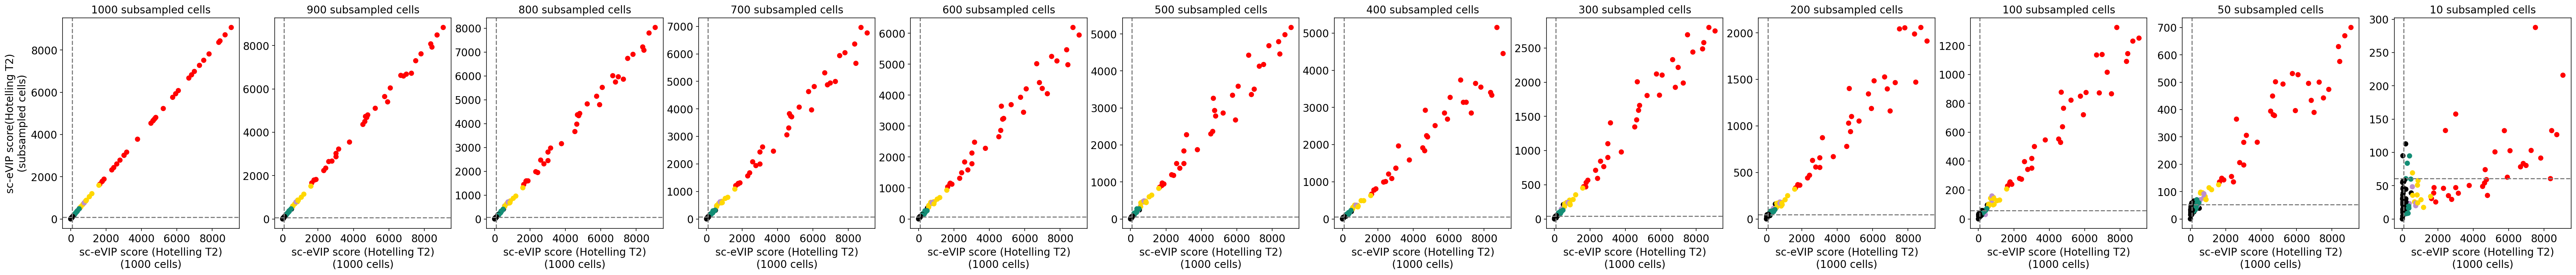

In [5]:
#show subsampling comparisons


SUBSAMPLING_LIST=[1000,900,800,700,600,500,400,300,200,100,50,10]

fig,plots=plt.subplots(1,len(SUBSAMPLING_LIST))
fig.set_size_inches(len(SUBSAMPLING_LIST)*5,5)

ref='P359P'
method='HotellingT2'
#synonymous
OUT_PREF=DATA+'/'+PROTEIN+'/scoring/'+PROTEIN

iter_name='0'
out_here=OUT_PREF+'.cellsPerVar1000.iter'+str(iter_name)+'.scores.gz'
reference_data=pd.read_csv(out_here,sep='\t')
reference_data.index=reference_data['group2']
fdr_thresh_reference=get_threshold_at_FDR(reference_data,
                                          method,FDR=0.01,higher=True)
print(reference_data.head())
i=0
for subs_idx,subs in enumerate(SUBSAMPLING_LIST):
    out_here=OUT_PREF+'.cellsPerVar'+str(subs)+'.iter'+str(iter_name)+'.scores.gz'
    scores=pd.read_csv(out_here,sep='\t')
    scores.index=scores['group2']
    common=list(set(anno.index,).intersection(set(reference_data.index)))
    fdr_thresh=get_threshold_at_FDR(scores,method,FDR=0.01,higher=True)
    
    plots[i].scatter(reference_data.loc[common,method],
                     scores.loc[common,method],
                    c=anno.loc[common,'Cluster'])
    plots[i].axhline(y=fdr_thresh,linestyle='--',color='gray')
    plots[i].axvline(x=fdr_thresh_reference,linestyle='--',color='gray')
    plots[i].grid(False)
    plots[i].set_title(str(subs)+' subsampled cells')
    plots[i].set_xlabel('sc-eVIP score (Hotelling T2)\n(1000 cells)')
    if i==0:
        plots[i].set_ylabel('sc-eVIP score(Hotelling T2)\n(subsampled cells)')
    else:
        plots[i].set_ylabel('')
    #plots[i].set_xscale('log')
    #plots[i].set_yscale('log')
    i+=1
 
plt.savefig(FIGS+'/'+PROTEIN+'.subsampling.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.subsampling.png',bbox_inches = "tight")